In [206]:
import random
import json
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)


# Experiment ? - Llama3.2 3b on chat mode

In this experiment I feed the the model a revisioned version of the input, where the STSG is put the beginning of the prompt and the question with the alternatives at the end. Finally I ask the model to reason about the possible answer *step by step*, conditioning it to perform Zero-Shot-CoT (Prompt engineering technique where no example of thow to perform the reasoning is provided -- no in-context learning). Moreover, instead of asking the model to provide the answer on the same promtp, I instatied the model in multi-turn chat mode where, after the model gives the first response, a script sends an automatic reply asking to extract the final answer given by the model and give it a json format.

**Parameters:**
- model: llama3.2 3b
- system prompt: MCQ_system_promtp_ZS_CoT.txt
- user_prompt: MCQ_user_prompt_ZS_CoT_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


## Prompts

In [207]:
os.listdir()


['resp_analysis6_deepseek.ipynb',
 'resp_analysis5.ipynb',
 'week_0317_zero_shot_cot_chat_prompting.ipynb',
 'resp_analysis4_ZS.ipynb',
 'resp_analysis6_phi3.ipynb',
 'week_0310_llama8b_as_judgeon_extracted_answers.ipynb',
 'week_0224_llama8b_as_judge.ipynb',
 'blame.txt',
 'resp_analysis6_deepseek7b.ipynb',
 'week_0224_correlation_llama3bvs8b.ipynb',
 'resp_analysis6_llama8b.ipynb',
 'resp_analysis6_llama3b.ipynb',
 'resp_analysis.ipynb',
 'week_0303_llama8b_as_judge_improving_correlation.ipynb',
 'resp_analysis3.ipynb',
 'week_0234_oneshot_nohtml_tags.ipynb',
 'resp_analysis4_OS.ipynb',
 'resp_analysis2.ipynb',
 'week_0224_llama3b_bias_check.ipynb',
 'week_0303_resp_analysis6_llama8b_regex_extract_last.ipynb',
 'hallucinations_investigation.ipynb']

In [208]:
with open('../data/prompts/zero-shot-cot/MCQ_system_prompt_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


You need to respond to reasoning questions by making logical inference on sequence of Scene-Graphs extracted from frames belonging to a video, called a Spatio-Temporal Scene Graph.

IMPORTANT CLARIFICATIONS:
- You will receive a question and Spatio-Temporal Scene-Graph
- Each Scene-Graph is a static symbolic representation of the scene unfolding in the frame
- The Scene-Graphs are ordered chronologically
- The Scene-Graph is represented as a set of tuple in the format: subject - relationship - object
- The Spatio-Temporal Scene-Graph is a cornologically sorted list of Scene-Graphs

INSTRUCTIONS:
- Read the entire Spatio-Temporal Scene-Graphs in chronological order and pay attention at the order of how events unfold.
- Read the question and reason about the answer step by step.
- In your answer include key events or relationships that help you in determing the correct answer.
- Be careful to reproduce the chosen alternative as it is presented.


In [209]:
with open('../data/prompts/zero-shot-cot/MCQ_user_prompt_ZS_CoT_v2.txt', 'r') as f:
    pr = f.read()

print(pr)


Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:

<STSG>
{stsg}
</STSG>

Given the following question:
<Q>
{question}
<Q>

And the following alternatives:
<Alternatives>
A. {c1}
B. {c2}
C. {c3}
D. {c4}
</Alternatives>

Provide an answer to the above question reasoning step by step on the Spatio-Temporal Scene-Graph (STSG) and choosing one of the alternatives.


In [210]:
reply = """\
Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\
"""

print(reply)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [211]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


## Loading predicted answers evaluation

In [212]:
predictions = []
with open('../outputs/responses_llama3.2_20250321_10:18:36_chat.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': ""Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': ""Please carefully..."


In [213]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': 'Please carefully..."


In [214]:
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])
# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'] .str.match(r'^\s*{[^}]+}\s*$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 7098
Answers following JSON template: 7095
Percentage following JSON template: 99.96%


Here we have wrong formantting, regardless of the correctness of the answer

In [215]:
predictions_df[~json_mask]['answer'].iloc[0]

'{"answer": "I couldn"}}'

In [216]:
predictions_df[~json_mask]['answer'].iloc[1]

'{"answer": "B. Threw the clothes is not supported by the STSG as there are no instances where the person throws anything, however, looking at the next part of the STSG: [[\'person - touching- towel\', ...]], we can see that after the person put down the blanket, they started using a towel. This suggests that the person was trying to clean themselves or dry something. Therefore, option D is not supported by the STSG as there are no instances where the person puts anything down. However, looking at the next part of the STSG: [[\'person - touching- towel\', ...]], we can see that after the person put down the blanket, they started using a towel. This suggests that the person was trying to clean themselves or dry something. Considering this information and the options provided, we cannot directly conclude any of the alternatives as correct based on the STSG alone. However, if we consider the context of the question \\u201CWhat happened after the person put down the blanket?\\\\u201D it se

In [217]:
predictions_df[~json_mask]['answer'].iloc[2]

'{"answer": "D. Tidied up the clothes is incorrect because there is no scene where the person tidies up the clothes, but A. Took the food is also incorrect because it does not make sense in this context, B. Put down the food and C. Threw the towel are also incorrect. The correct answer is D. Tidied up the clothes is incorrect, therefore the correct answer is:  \'person - eating - sandwich\' appears in multiple scenes. The scene where the person is eating food also mentions \'person - eating - sandwich\', which implies that after holding the sandwich, the person ate it. Therefore, the correct answer is A. Took the food (no, this is incorrect) -> B. Put down the food (no, this is incorrect) -> C. Threw the towel (no, this is incorrect) -> D. Tidied up the clothes (no, this is incorrect). The best alternative to choose from the given options would be: A. Took the food (no, this is incorrect) -> B. Put down the food (no, this is incorrect) -> C. Threw the towel (no, this is incorrect) -> D

In [218]:
eval(predictions_df[json_mask]['answer'].iloc[0])['answer']

'C. The clothes.'

In [219]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df.loc[~json_mask, 'answer'] = ""

In [220]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")

Answer following the template: 7068
99.58% of the total

Only 30 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_32783/4018721229.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [221]:
predictions_df.loc[~contains_answer, 'answer']

id
Interaction_T1_532                   None of the above (C). The blanket.
Interaction_T1_3211                                   None of the above.
Interaction_T1_4128    None of the above alternatives can be confiden...
Interaction_T1_6343                                    None of the above
Interaction_T1_6756    There is no clear evidence in the Spatio-Tempo...
Interaction_T2_277     None of the alternatives (A. Washed, B. Tidied...
Interaction_T2_6358    None of the above. The person was holding and ...
Interaction_T4_931                                                      
Interaction_T4_1092                                    None of the above
Interaction_T4_1484            None of the above. A. Put down the towel.
Interaction_T4_1654    We cannot determine what the person did with t...
Interaction_T4_2161    Unknown. The scene graph does not provide any ...
Interaction_T4_4709                                    None of the above
Sequence_T1_28         None of the alternatives 

In [222]:
gt_df

,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


## Extract answers

In [223]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_13,The clothes.
Interaction_T1_14,The blanket.
Interaction_T1_31,The bag.
Interaction_T1_32,The shoe.
Interaction_T1_40,The blanket.
...,...
Feasibility_T6_1453,Wash the table.
Feasibility_T6_1454,Take the towel.
Feasibility_T6_1455,Wash the table.


In [224]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7068 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7068 non-null   object
dtypes: object(1)
memory usage: 110.4+ KB


In [225]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 1520 unique answers


In [226]:
ans_df['text'].value_counts()


The towel.                                                 217
The bag.                                                   212
The clothes.                                               186
The box.                                                   183
The book.                                                  182
                                                          ... 
Took the broom after putting down the cup/glass/bottle.      1
Put down the towel after taking the blanket.                 1
Tidied up the towel after holding the clothes.               1
Took the food after lying on the bed.                        1
Throw the food.                                              1
Name: text, Length: 760, dtype: int64

<AxesSubplot: xlabel='freq', ylabel='word'>

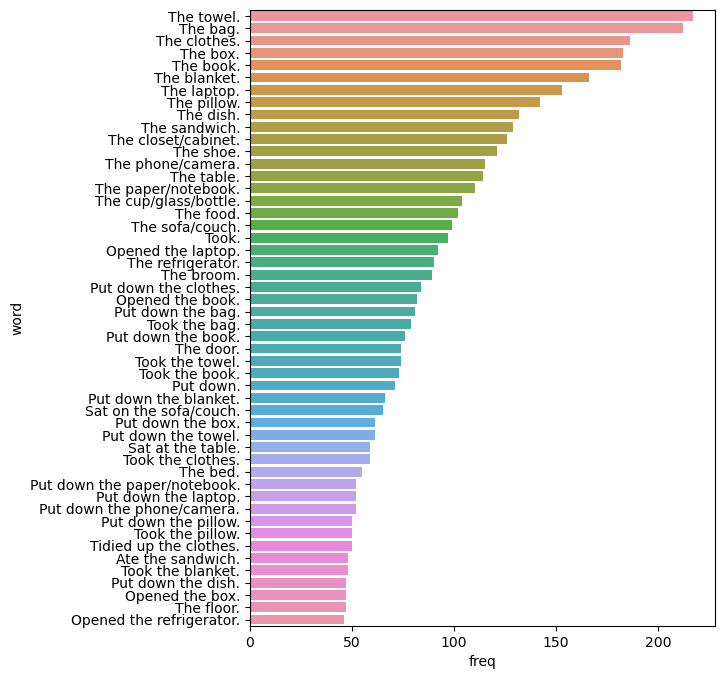

In [227]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [228]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


<AxesSubplot: xlabel='freq', ylabel='word'>

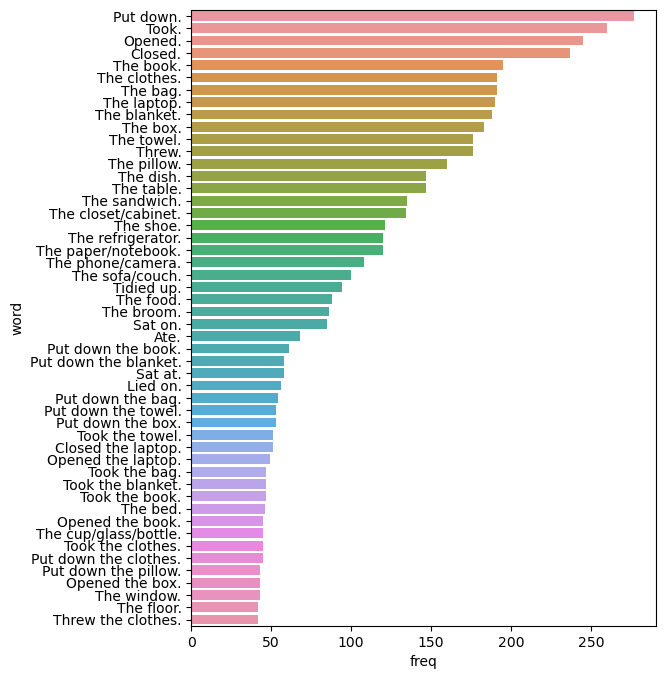

In [229]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [230]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(7068, 5)

In [231]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


check if the equality with NA result in a false or is skipped

In [232]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 53.83%


In [233]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [234]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2385        49.56%  
Sequence            3572        54.54%  
Prediction           623        62.12%  
Feasibility          488        62.30%  


In [236]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        99.46%  
Sequence            3586        99.61%  
Prediction           624        99.84%  
Feasibility          490        99.59%  
Overall             7098        99.58%  
